In [44]:
%load_ext autoreload
%autoreload 2
%env CUDA_VISIBLE_DEVICES=1
import matplotlib.pyplot as plt
from utils.utils import get_path
from utils.io_utils import load_multiple_res
from utils.pd_utils import filter_dgms, compute_outlier_scores
from utils.fig_utils import full_dist_to_print, full_dist_to_color, dataset_to_print, dist_to_print, dist_to_color, plot_edges_on_scatter
import glasbey
import os
import numpy as np
import copy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
env: CUDA_VISIBLE_DEVICES=1


In [45]:
style_file = "utils.style"
plt.style.use(style_file)

In [46]:
root_path = get_path("data")
fig_path = os.path.join(root_path, "figures")

# Figure on PCA results

In [47]:
# hyperparameters
distances = {
    "euclidean": [{}],
    "eff_res": [
        {"corrected": True, "weighted": False, "k": 15, "disconnect": True},
        {"corrected": True, "weighted": False, "k": 100, "disconnect": True},
    ],
    "pca": [
        {"n_components": 2, "normalize": False},
        {"n_components": 3, "normalize": False},
        {"n_components": 5, "normalize": False},
        {"n_components": 10, "normalize": False},
        {"n_components": 20, "normalize": False},

        {"n_components": 2, "normalize": True},
        {"n_components": 3, "normalize": True},
        {"n_components": 5, "normalize": True},
        {"n_components": 10, "normalize": True},
        {"n_components": 20, "normalize": True},
    ],
}

# Real data

In [37]:
distances["correlation"] =  [{}],


In [ ]:
datasets = ["mca_ss2", "neurosphere_gopca_small", "hippocampus_gopca_small", "pallium_scVI_IPC_small", "HeLa2_gopca", "pancreas_gopca"]

seeds = [0, 1, 2]

n_loops = {dataset: 1 if dataset != "mca_ss2" else 2 for dataset in datasets}

In [9]:
# make copy of the distance dict with correlation as input distance for malaria dataset
distances_corr = copy.deepcopy(distances)
for distance in distances_corr:
    if distance in ["euclidean", "cosine", "correlation"]:
        continue
    for dist_kwargs in distances_corr[distance]:
        dist_kwargs["input_distance"] = "correlation"
        if "metric" in dist_kwargs:
            del dist_kwargs["metric"]

In [10]:
# load PH results (using correlation as input distance for malaria dataset)
all_res = {}
for dataset in datasets:
    dists = distances if dataset != "mca_ss2" else distances_corr
    all_res[dataset] = load_multiple_res(datasets=dataset, 
                                         n=None, 
                                         embd_dims=None,
                                         sigmas=None,
                                         distances=dists,
                                         seeds=seeds,
                                         root_path=root_path,
                                         n_threads=1)

Done with mca_ss2 None euclidean n_outliers=0, perturbation=None
Done with mca_ss2 None correlation n_outliers=0, perturbation=None
Done with mca_ss2 None eff_res_corrected_True_weighted_False_k_15_disconnect_True_input_distance_correlation n_outliers=0, perturbation=None
Done with mca_ss2 None eff_res_corrected_True_weighted_False_k_100_disconnect_True_input_distance_correlation n_outliers=0, perturbation=None
Done with mca_ss2 None pca_n_components_2_normalize_False_input_distance_correlation n_outliers=0, perturbation=None
Done with mca_ss2 None pca_n_components_3_normalize_False_input_distance_correlation n_outliers=0, perturbation=None
Done with mca_ss2 None pca_n_components_5_normalize_False_input_distance_correlation n_outliers=0, perturbation=None
Done with mca_ss2 None pca_n_components_10_normalize_False_input_distance_correlation n_outliers=0, perturbation=None
Done with mca_ss2 None pca_n_components_20_normalize_False_input_distance_correlation n_outliers=0, perturbation=Non

In [11]:
# filtering
dob = 1.25
all_res = filter_dgms(all_res, dob=dob, binary=True, dim=1)

In [12]:
# compute the detection scores
outlier_scores = {}
for dataset in datasets:
    outlier_scores[dataset] = compute_outlier_scores(all_res[dataset], n_features=n_loops[dataset], dim=1)

In [20]:
block_lengths = [5, 5 ]
new_colors = glasbey.create_block_palette(block_lengths,
                                      generated_color_lightness_bounds= (20, 60),
                                      generated_color_chroma_bounds = (20, 100),
                                      max_lightness_bend=40)

full_dist_to_color.update({f"pca_n_components_{n_components}_normalize_{normalize}": new_colors[i] for i, (n_components, normalize) in enumerate([(n_comp, norm) for norm in [False, True] for n_comp in [2, 3, 5, 10, 20] ])})

In [21]:
norm_str = ["not normalized", "normalized"]
full_dist_to_print.update({f"pca_n_components_{n_components}_normalize_{normalize}": f"{n_components} PCs {norm_str[normalize]}" 
                           for n_components in [2, 3, 5, 10, 20] for normalize in [False, True]})

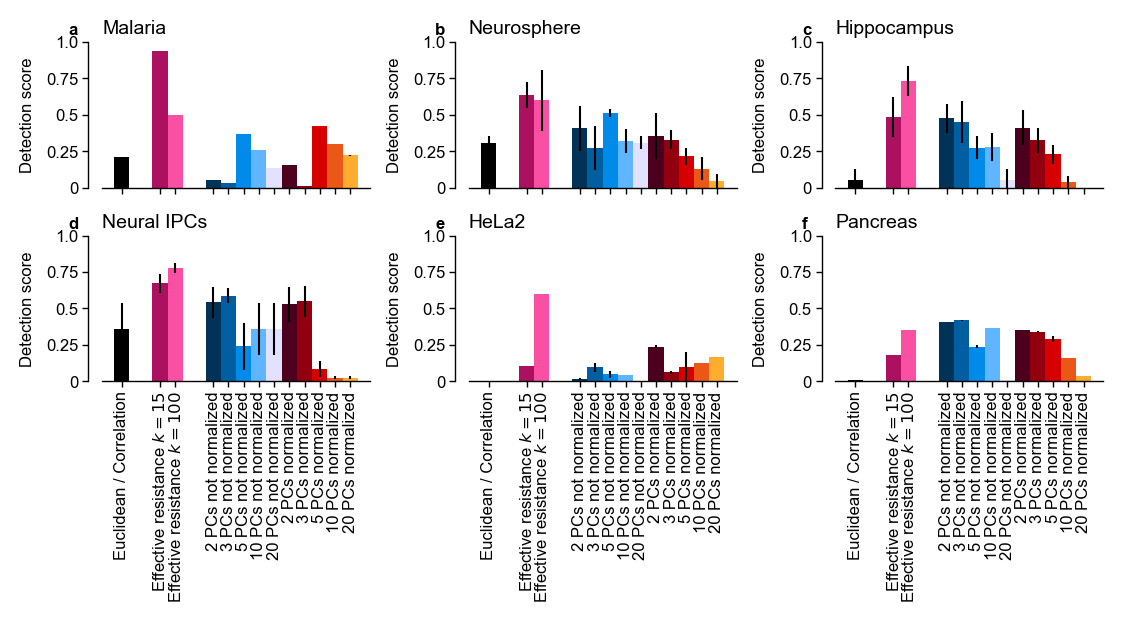

In [29]:
# plot figure
plt.rcParams.update({'hatch.color': 'w'})

n_cols = 3
n_rows = np.ceil(len(datasets) /n_cols).astype(int)
fig, ax = plt.subplots(ncols=n_cols, nrows=n_rows, figsize=(5.5, 3))

bar_width = 0.2
sep = 1.5 * bar_width

letters = "abcdefghi"

for i, dataset in enumerate(datasets):
    # one row per dataset
    
    r, c = divmod(i, n_cols)
    
    cax = ax[r, c]
    x_vals = [0]
    shift = 0
    full_dists = []
    for j, dist in enumerate(outlier_scores[dataset]):    
        # show correlation distance for malaria and euclidean distance for the other dataset. The shift handles the correct distance selection.
        if dataset == "mca_ss2":
            if dist == "euclidean":
                shift = -1
                continue
            elif dist == "correlation":
                full_dist_for_color = "euclidean"
                full_dist_for_print = "correlation"
        else:
            if dist == "correlation":
                shift = -1
                continue
                
        j+=shift
        x_val = x_vals[-1] + sep
        
        # plot all hyperparameter results for this distance in on block
        for k, full_dist in enumerate(outlier_scores[dataset][dist]):
            x_val += bar_width
            x_vals.append(x_val)

            full_dist_for_color = full_dist.removesuffix("_input_distance_correlation")
                            
            if dist == "umap_embd":
                full_dist_for_color += "_metric_euclidean"
                
            if dataset == "mca_ss2" and dist == "correlation":
                full_dist_for_color = "euclidean"
            else:
                full_dist_for_color = full_dist_for_color
                
            full_dists.append(full_dist_for_color)

            cax.bar(x_val, 
                   outlier_scores[dataset][dist][full_dist].mean(), 
                   bar_width, 
                   yerr=outlier_scores[dataset][dist][full_dist].std(), 
                   label=full_dist_to_print[full_dist_for_color],
                   color = full_dist_to_color[full_dist_for_color]
                   )
        
    # prettify the panel
    cax.set_ylim(0.0, 1.0)
    cax.set_xticks([])
    cax.set_xticklabels([])

    cax.set_yticks([0, 0.25, 0.5, 0.75, 1.0])
    
    cax.set_ylabel("Detection score")
    cax.set_yticklabels([0, 0.25, 0.5, 0.75, 1.0])

    cax.set_title(dataset_to_print[dataset], loc="left")
    cax.text(
        -0.2,
        1.05,
        letters[i],
        fontweight="bold"
    )

    cax.spines['left'].set_position(('outward', 5))

    cax.set_xticks(x_vals[1:])
    
    if r == n_rows - 1:
        cax.set_xticklabels(["Euclidean / Correlation"] + [full_dist_to_print[full_dist].replace("\n", " ") for full_dist in full_dists[1:]], 
                            rotation=90)

fig.savefig(os.path.join(fig_path, "fig_scRNAseq_pca.png"))  

# Toy datasets

In [48]:
datasets = ["toy_circle", "inter_circles", "eyeglasses"] #, "torus", "toy_sphere"]

embd_dim = 50
sigmas = np.linspace(0.0, 0.35, 29)
sigmas = np.array([np.format_float_positional(sigma, precision=4, unique=True, trim='0') for sigma in sigmas]).astype(float)
seeds = [0, 1, 2]
n = 1000

# different datas
sigmas_per_dataset = {}
for dataset in datasets:
    if dataset == "eyeglasses":
        sigmas_per_dataset[dataset] = sigmas[:13]
    else:
        sigmas_per_dataset[dataset] = sigmas

## Find best hyperparameters

In [49]:
#load data
all_res = {}
for dataset in datasets:
    all_res[dataset] = load_multiple_res(datasets=dataset,
                                         distances=distances,
                                         root_path=get_path("data"),
                                         n=n,
                                         seeds=seeds,
                                         sigmas=sigmas_per_dataset[dataset],
                                         embd_dims=embd_dim,
                                         n_threads=10)

Done with toy_circle 50 euclidean n_outliers=0, perturbation=None
Done with toy_circle 50 eff_res_corrected_True_weighted_False_k_15_disconnect_True n_outliers=0, perturbation=None
Done with toy_circle 50 eff_res_corrected_True_weighted_False_k_100_disconnect_True n_outliers=0, perturbation=None
Done with toy_circle 50 pca_n_components_2_normalize_False n_outliers=0, perturbation=None
Done with toy_circle 50 pca_n_components_3_normalize_False n_outliers=0, perturbation=None
Done with toy_circle 50 pca_n_components_5_normalize_False n_outliers=0, perturbation=None
Done with toy_circle 50 pca_n_components_10_normalize_False n_outliers=0, perturbation=None
Done with toy_circle 50 pca_n_components_20_normalize_False n_outliers=0, perturbation=None
Done with toy_circle 50 pca_n_components_2_normalize_True n_outliers=0, perturbation=None
Done with toy_circle 50 pca_n_components_3_normalize_True n_outliers=0, perturbation=None
Done with toy_circle 50 pca_n_components_5_normalize_True n_outlie

In [50]:
# filtering
dob = 1.25
all_res = filter_dgms(dgms=all_res, dob=dob, dim=1, binary=True)
#all_res = filter_dgms(dgms=all_res, dob=dob, dim=2, binary=True)

In [51]:
# compute the detection score
cycles_per_dataset = {
    1: {
        "toy_circle": 1,
        "inter_circles": 2,
        "eyeglasses": 1,
        #"torus": 2,
        #"toy_sphere": 0,  # so that the curves are high for AUC
    },
    #2: {
    #    "toy_sphere": 1,
    #    "torus": 1 
    #}
}

outlier_scores_1d = {dataset: compute_outlier_scores(all_res[dataset], 
                                                     n_features=cycles_per_dataset[1][dataset],
                                                     dim=1)
                     for dataset in cycles_per_dataset[1]}
#outlier_scores_2d = {dataset: compute_outlier_scores(all_res[dataset],
#                                                     n_features=cycles_per_dataset[2][dataset],
#                                                     dim=2)
#                     for dataset in cycles_per_dataset[2]}

outlier_scores = {
    1: outlier_scores_1d,
    #2: outlier_scores_2d
}

In [52]:
new_dict = {}

for dataset in outlier_scores[1]:
    new_dict = {}

    for full_dist in outlier_scores[1][dataset]["pca"]:
        if "normalize_True" in full_dist:
            new_dict[full_dist] = outlier_scores[1][dataset]["pca"][full_dist].copy()

    for key in new_dict:
        del outlier_scores[1][dataset]["pca"][key]
    outlier_scores[1][dataset]["pca_norm"] = new_dict

In [53]:
block_lengths = [5, 5]
new_colors = glasbey.create_block_palette(block_lengths,
                                          generated_color_lightness_bounds=(20, 60),
                                          generated_color_chroma_bounds=(20, 100),
                                          max_lightness_bend=40)

full_dist_to_color.update(
    {f"pca_n_components_{n_components}_normalize_{normalize}": new_colors[i] for i, (n_components, normalize) in
     enumerate([(n_comp, norm) for norm in [False, True] for n_comp in [2, 3, 5, 10, 20]])})

dist_to_color.update({"pca": new_colors[2], "pca_norm": new_colors[7]})

In [54]:
norm_str = ["not normalized", "normalized"]
full_dist_to_print.update(
    {f"pca_n_components_{n_components}_normalize_{normalize}": f"{n_components} PCs {norm_str[normalize]}"
     for n_components in [2, 3, 5, 10, 20] for normalize in [False, True]})

dist_to_print.update({"pca": "PCA", "pca_norm": "Normalized PCA"})

### find best hyperparameters per method

In [55]:
# compute area under the curves
aucs = {}

for feature_dim in outlier_scores:
    auc_by_feature_dim = {}
    for dataset in outlier_scores[feature_dim]:
        auc_by_dataset = {}
        for dist in outlier_scores[feature_dim][dataset]:
            auc_per_method = {}
            for full_dist in outlier_scores[feature_dim][dataset][dist]:
                auc_per_method[full_dist] = outlier_scores[feature_dim][dataset][dist][full_dist].mean(1).sum() / len(sigmas_per_dataset[dataset])
            auc_by_dataset[dist] = auc_per_method
        auc_by_feature_dim[dataset] = auc_by_dataset
    aucs[feature_dim] = auc_by_feature_dim

In [56]:
# Each panel selects the best method individually. This means different feature dimensions for torus and sphere can select different hyperparameters.

best_method_per_dataset = {}
for feature_dim in aucs:
    best_method_per_feature_dim = {}

    for dataset in aucs[feature_dim]:
        best_method_this_dataset = {}
        for dist in aucs[feature_dim][dataset]:
            best_full_dist = None
            best_auc = 0
            for full_dist in aucs[feature_dim][dataset][dist]:
                auc = aucs[feature_dim][dataset][dist][full_dist]
                if auc > best_auc:
                    best_auc = auc
                    best_full_dist = full_dist
            best_method_this_dataset[dist] = best_full_dist
        best_method_per_feature_dim[dataset] = best_method_this_dataset
    best_method_per_dataset[feature_dim] = best_method_per_feature_dim

In [57]:
best_method_per_dataset

{1: {'toy_circle': {'euclidean': 'euclidean',
   'eff_res': 'eff_res_corrected_True_weighted_False_k_100_disconnect_True',
   'pca': 'pca_n_components_2_normalize_False',
   'pca_norm': 'pca_n_components_2_normalize_True'},
  'inter_circles': {'euclidean': 'euclidean',
   'eff_res': 'eff_res_corrected_True_weighted_False_k_15_disconnect_True',
   'pca': 'pca_n_components_3_normalize_False',
   'pca_norm': 'pca_n_components_3_normalize_True'},
  'eyeglasses': {'euclidean': 'euclidean',
   'eff_res': 'eff_res_corrected_True_weighted_False_k_15_disconnect_True',
   'pca': 'pca_n_components_2_normalize_False',
   'pca_norm': 'pca_n_components_2_normalize_True'}}}

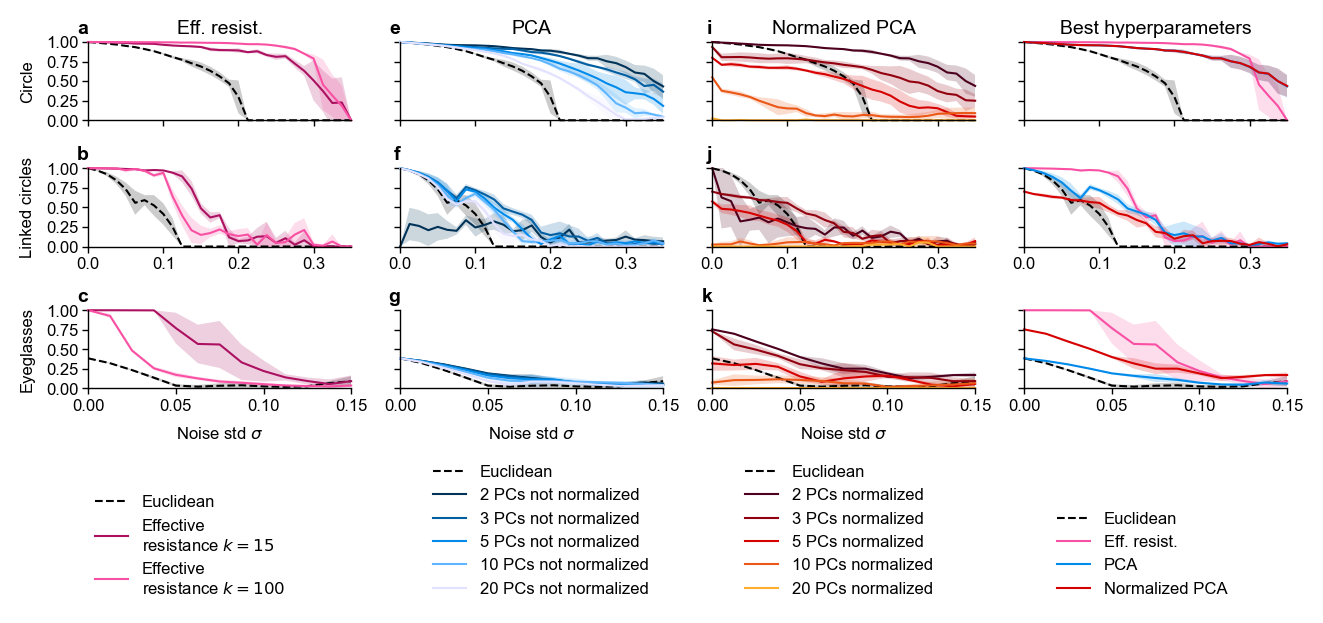

In [60]:
# plot all results
ncols = 4
nrows = len(datasets)

letters = "abcdefghijklmnopqrst"


fig, ax = plt.subplots(nrows=nrows+1, ncols=ncols, figsize=(6.5, 3.))


for j, dataset in enumerate(outlier_scores[1]):
    ax[j, 0].set_ylabel(dataset_to_print[dataset])
    
    
    for i in range(ncols-1):
        method_id = i+1
        dist = list(outlier_scores[1][dataset].keys())[method_id]
        
        # plot euclidean for reference
        scores = outlier_scores[1][dataset]["euclidean"]["euclidean"]
        mean = scores.mean(1)
        std = scores.std(1)
        ax[j, i].plot(sigmas_per_dataset[dataset], 
                   mean,
                   label="Euclidean",
                   c=dist_to_color["euclidean"],
                   clip_on=False,
                   linestyle="dashed")
        ax[j, i].fill_between(sigmas_per_dataset[dataset],
                           mean-std,
                           mean+std,
                           alpha=0.2,
                           color=dist_to_color["euclidean"],
                           edgecolor="none",
        )
        

        for submethod_counter, full_dist in enumerate(outlier_scores[1][dataset][dist]):
            scores =  outlier_scores[1][dataset][dist][full_dist]
            mean = scores.mean(1)
            std = scores.std(1)
            ax[j, i].plot(sigmas_per_dataset[dataset], 
                       mean,
                       label=full_dist_to_print[full_dist],
                       c=full_dist_to_color[full_dist],
                       clip_on=False,)
            ax[j, i].fill_between(sigmas_per_dataset[dataset],
                               mean-std,
                               mean+std,
                               alpha=0.2,
                               color=full_dist_to_color[full_dist],
                               edgecolor="none",               
            )
            if j == 0:
                ax[j, i].set_title(f"{dist_to_print[dist]}")
            
            ax[j, i].set_ylim(0, 1)
            ax[j, i].set_xlim(0, sigmas_per_dataset[dataset].max())
            
        if j==2:  
            ax[j, i].set_xlabel("Noise std $\sigma$")
            #ax[j, i].legend(loc=(0.0, -1.9), frameon=False)
        elif j == 0 or j == 1:
            ax[j, i].set_xticks([0.0, 0.1, 0.2, 0.3])
            if j ==0:
                ax[j, i].set_xticklabels([])

        ax[j, i].set_yticks([0.0, 0.25, 0.5, 0.75, 1.0])
        if i != 0:
            ax[j, i].set_yticklabels([])
            
        ax[j, i].set_title(
            letters[j+i*ncols],
        loc="left",
        ha="right",
        fontweight="bold",
        )
            
    # print best method
    for dist in  best_method_per_dataset[1][dataset]:
        linestyle = "dashed" if dist == "euclidean" else "solid"
        full_dist = best_method_per_dataset[1][dataset][dist]
        scores = outlier_scores[1][dataset][dist][full_dist]
        mean = scores.mean(1)
        std = scores.std(1)
        ax[j, -1].plot(sigmas_per_dataset[dataset], 
                       mean,
                       label=dist_to_print[dist],
                       c=dist_to_color[dist],
                       clip_on=False,
                       linestyle=linestyle)
        ax[j, -1].fill_between(sigmas_per_dataset[dataset],
                           mean-std,
                           mean+std,
                           alpha=0.2,
                           color=dist_to_color[dist],
                           edgecolor="none",
        )
        ax[j, -1].set_ylim(0, 1)
        ax[j, -1].set_xlim(0, sigmas_per_dataset[dataset].max())
        ax[j, -1].set_yticks([0.0, 0.25, 0.5, 0.75, 1.0])
        ax[j, -1].set_yticklabels([])
        if j < 2:
            ax[j, -1].set_xticks([0.0, 0.1, 0.2, 0.3])
        if j ==0:
            ax[j, -1].set_xticklabels([])

ax[0, -1].set_title("Best hyperparameters")



for i in range(ncols):
    handles, labels = ax[0, i].get_legend_handles_labels()
    if i == 0:
        legend = ax[-1, i].legend(loc=(0.0, 0),
                                  ncols=1,
                                  handles=handles,
                                  frameon=False
                                  )
    else:
        legend = ax[-1, i].legend(loc=(0.1, 0),
                                  ncols=1,
                                  handles=handles,
                                  frameon=False
                                  )

    ax[-1, i].axis("off")
    
fig.savefig(os.path.join(fig_path, f"fig_comparison_pcas.png"), dpi=300)
fig.savefig(os.path.join(fig_path, f"fig_comparison_pcas.pdf"))